# Trabajando con secuencias en Machine learning

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

http://philipperemy.github.io/keras-stateful-lstm/

In [7]:
import sys 
sys.path.append("../mllab-tools/")

In [76]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.utils import np_utils
from fnn_helper import PlotLosses

In [9]:
# Fijamos la semilla para que sea reprodicible
np.random.seed(7)

# Creamos frase

In [10]:
# phrase = "Machine learning lab: Redes Neuronales Recurrentes (LSTM)"
phrase = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print('Longitud de la frase:',len(phrase))
# create mapping of characters to integers (0-25) and the reverse
def create_dicts(phrase):
    alphabet = sorted(list(set(phrase)))
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    return alphabet, char_to_int, int_to_char
alphabet, char_to_int, int_to_char = create_dicts(phrase)
print(len(alphabet))
print(char_to_int)
print(int_to_char)

Longitud de la frase: 26
26
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [50]:
# prepare the dataset of input to output pairs encoded as integers
def prepare_dataset(phrase, seq_length = 1, verbose = True):
    alphabet, char_to_int, int_to_char = create_dicts(phrase)
    dataX = []
    dataY = []
    if verbose:
        print('Primeros 3 pares:')
    for i in range(0, len(phrase) - seq_length, 1):
        seq_in = phrase[i:i + seq_length]
        seq_out = phrase[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])
        if verbose and i<3:
            print(seq_in, '->', seq_out)
        # reshape X to be [samples, time steps, features]
    X = np.array(dataX).reshape((len(dataX), seq_length, 1))
    # en X_mlp time steps sería features
    X_mlp = X.reshape(len(dataX), seq_length)
    X_naive = np.reshape(dataX, (len(dataX), 1, seq_length))
    
    X = X / float(len(alphabet))
    X_mlp = X_mlp / float(len(alphabet))
    X_naive = X_naive / float(len(alphabet))
    # one hot encode the output variable
    y = np_utils.to_categorical(dataY)
    if verbose:
        print()
        print('X e y ya formateados para RNN:')
        print(X[0], '->', y[0])
        print(X[1], '->', y[1])
        print()
        print('Dimensiones de X para RNN [samples, time steps, features]')
        print(X.shape)
        print()
        print('Dimensiones de X_naive para RNN [samples, time steps, features]')
        print(X_naive.shape)
        print()
        print('Dimensiones de X_mpl para MLP [samples, features]')
        print(X_mlp.shape)
    return X, y, dataX, dataY, X_mlp, X_naive

** Probar distintos valores de seq_length: 3 y 1 **

In [52]:
X, y, dataX, dataY, X_mlp, X_naive = prepare_dataset(phrase, seq_length = 3, verbose=True)

Primeros 3 pares:
ABC -> D
BCD -> E
CDE -> F

X e y ya formateados para RNN:
[[ 0.        ]
 [ 0.03846154]
 [ 0.07692308]] -> [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.03846154]
 [ 0.07692308]
 [ 0.11538462]] -> [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Dimensiones de X para RNN [samples, time steps, features]
(23, 3, 1)

Dimensiones de X_naive para RNN [samples, time steps, features]
(23, 1, 3)

Dimensiones de X_mpl para MLP [samples, features]
(23, 3)


# Es posible trabajar con un MLP?

## MLP como baseline

In [70]:
def get_score(X, y, model): 
    # summarize performance of the model
    scores = model.evaluate(X, y, verbose=0)
    print("Model Accuracy: %.2f%%" % (scores[1]*100))

def get_some_model_predictions_MLP(model, dataX):
    # demonstrate some model predictions
    for pattern in dataX:
        x = np.array(pattern)
        x = x / float(len(alphabet))
        x = x.reshape(1,x.shape[0])
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        seq_in = [int_to_char[value] for value in pattern]
        print(seq_in, "->", result)
        
def get_some_model_predictions(model, dataX, naive=False):
    # demonstrate some model predictions
    for pattern in dataX:
        if naive:
            x = np.reshape(pattern, (1, 1, len(pattern)))
        else:
            x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(len(alphabet))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        seq_in = [int_to_char[value] for value in pattern]
        print(seq_in, "->", result)

In [54]:
def get_MLP_Model():
    # create and fit the model
    model = Sequential()
    input_dim = X_mlp.shape[1]
    print(input_dim)
    model.add(Dense(32, input_dim=input_dim))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model

In [38]:
model_MLP_1 = get_MLP_Model()
model_MLP_1.summary()

1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 26)                858       
Total params: 922
Trainable params: 922
Non-trainable params: 0
_________________________________________________________________


In [21]:
seq_length = 1
X, y, dataX, dataY, X_mlp = prepare_dataset(phrase, seq_length = seq_length, verbose=True)

Primeros 3 pares:
A -> B
B -> C
C -> D

X e y ya formateados para RNN:
[[ 0.]] -> [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.03846154]] -> [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Dimensiones de X para RNN [samples, time steps, features]
(25, 1, 1)

Dimensiones de X_mpl para MLP [samples, features]
(25, 1)


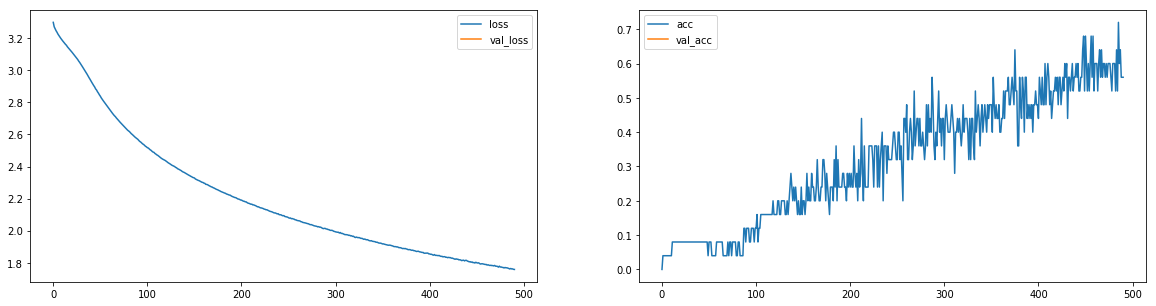

25/25 [==============================] - 0s - loss: 1.7586 - acc: 0.5600     
Epoch 492/500
25/25 [==============================] - 0s - loss: 1.7588 - acc: 0.5200     
Epoch 493/500
25/25 [==============================] - 0s - loss: 1.7589 - acc: 0.6400     
Epoch 494/500
25/25 [==============================] - 0s - loss: 1.7555 - acc: 0.6000     
Epoch 495/500
25/25 [==============================] - 0s - loss: 1.7530 - acc: 0.5600     
Epoch 496/500
25/25 [==============================] - 0s - loss: 1.7551 - acc: 0.5600     
Epoch 497/500
25/25 [==============================] - 0s - loss: 1.7550 - acc: 0.6000     
Epoch 498/500
25/25 [==============================] - 0s - loss: 1.7531 - acc: 0.6000        
Epoch 499/500
25/25 [==============================] - 0s - loss: 1.7525 - acc: 0.6400     
Epoch 500/500
25/25 [==============================] - 0s - loss: 1.7509 - acc: 0.6000     e+0 - ETA: 0s - loss: 1.7427 - acc: 0.6818   


In [32]:
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_MLP_1 = get_MLP_Model()
model_MLP_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_MLP_1.fit(X_mlp, y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [35]:
get_score(X_mlp, y, model_MLP_1)
get_some_model_predictions_MLP(model_MLP_1, dataX)

Model Accuracy: 80.00%
['A'] -> B
['B'] -> B
['C'] -> D
['D'] -> E
['E'] -> F
['F'] -> G
['G'] -> H
['H'] -> I
['I'] -> J
['J'] -> K
['K'] -> L
['L'] -> M
['M'] -> N
['N'] -> O
['O'] -> P
['P'] -> Q
['Q'] -> R
['R'] -> S
['S'] -> T
['T'] -> V
['U'] -> V
['V'] -> X
['W'] -> Z
['X'] -> Z
['Y'] -> Z


## LSTM

### Naive LSTM: Como NO usar una RNN

In [78]:
def get_naive_LSTM(input_shape):
    # create and fit the model
    model = Sequential()
    print(input_shape)
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model

def get_simple_RNN(input_shape):
    # create and fit the model
    model = Sequential()
    print(input_shape)
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model

In [61]:
input_shape=(X.shape[1], X.shape[2])
model_naive = get_naive_LSTM(input_shape)
model_naive.summary()

(3, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_18 (Dense)             (None, 26)                858       
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
_________________________________________________________________


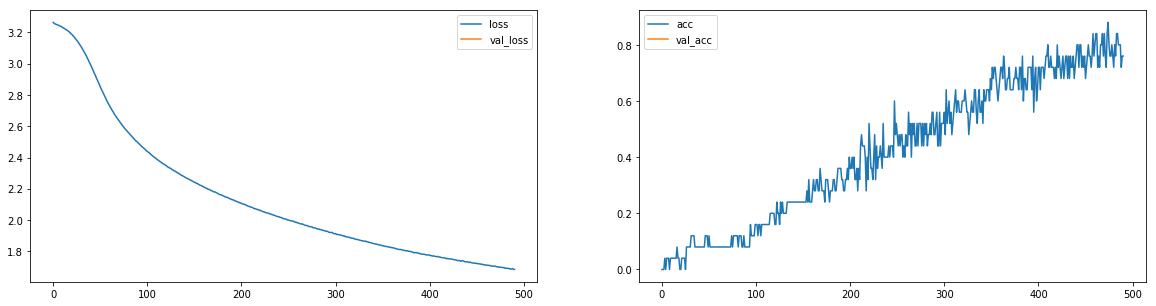

25/25 [==============================] - 0s - loss: 1.6843 - acc: 0.7600     
Epoch 492/500
25/25 [==============================] - 0s - loss: 1.6848 - acc: 0.8000     
Epoch 493/500
25/25 [==============================] - 0s - loss: 1.6830 - acc: 0.8400     
Epoch 494/500
25/25 [==============================] - 0s - loss: 1.6821 - acc: 0.8400     
Epoch 495/500
25/25 [==============================] - 0s - loss: 1.6803 - acc: 0.7600     
Epoch 496/500
25/25 [==============================] - 0s - loss: 1.6823 - acc: 0.8400     
Epoch 497/500
25/25 [==============================] - 0s - loss: 1.6783 - acc: 0.7200     
Epoch 498/500
25/25 [==============================] - 0s - loss: 1.6791 - acc: 0.8000     
Epoch 499/500
25/25 [==============================] - 0s - loss: 1.6796 - acc: 0.8000      
Epoch 500/500
25/25 [==============================] - 0s - loss: 1.6755 - acc: 0.8400     


In [36]:
model_naive = get_naive_LSTM()
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_naive.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_naive.fit(X, y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [39]:
get_score(X, y, model_naive)
get_some_model_predictions(model_naive, dataX)

Model Accuracy: 84.00%
['A'] -> B
['B'] -> C
['C'] -> D
['D'] -> E
['E'] -> F
['F'] -> G
['G'] -> H
['H'] -> I
['I'] -> J
['J'] -> K
['K'] -> L
['L'] -> M
['M'] -> N
['N'] -> O
['O'] -> P
['P'] -> Q
['Q'] -> R
['R'] -> S
['S'] -> T
['T'] -> U
['U'] -> W
['V'] -> X
['W'] -> Z
['X'] -> Z
['Y'] -> Z


## Ventana de 3 features  ->  1 caracter

In [56]:
seq_length = 3
X, y, dataX, dataY, X_mlp, X_naive = prepare_dataset(phrase, seq_length = seq_length, verbose=True)

Primeros 3 pares:
ABC -> D
BCD -> E
CDE -> F

X e y ya formateados para RNN:
[[ 0.        ]
 [ 0.03846154]
 [ 0.07692308]] -> [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.03846154]
 [ 0.07692308]
 [ 0.11538462]] -> [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Dimensiones de X para RNN [samples, time steps, features]
(23, 3, 1)

Dimensiones de X_naive para RNN [samples, time steps, features]
(23, 1, 3)

Dimensiones de X_mpl para MLP [samples, features]
(23, 3)


In [79]:
input_shape=(X_naive.shape[1], X_naive.shape[2])
model_naive_3 = get_simple_RNN(input_shape)
model_naive_3.summary()

(1, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1152      
_________________________________________________________________
dense_23 (Dense)             (None, 26)                858       
Total params: 2,010
Trainable params: 2,010
Non-trainable params: 0
_________________________________________________________________


** Observar la cantidad de parametros en la capa LSTM y compararla con la LSTM del ejemplo enterior **

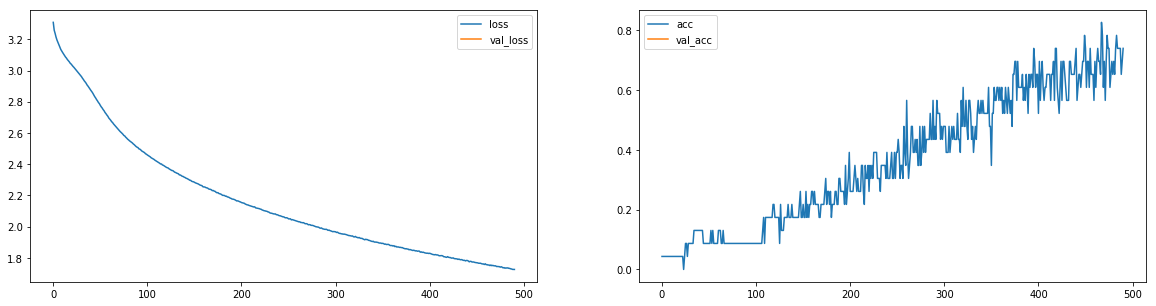

23/23 [==============================] - 0s - loss: 1.7260 - acc: 0.7391     
Epoch 492/500
23/23 [==============================] - 0s - loss: 1.7254 - acc: 0.7391     
Epoch 493/500
23/23 [==============================] - 0s - loss: 1.7245 - acc: 0.6957     
Epoch 494/500
23/23 [==============================] - 0s - loss: 1.7220 - acc: 0.6957     
Epoch 495/500
23/23 [==============================] - 0s - loss: 1.7235 - acc: 0.6522     
Epoch 496/500
23/23 [==============================] - 0s - loss: 1.7243 - acc: 0.6957        
Epoch 497/500
23/23 [==============================] - 0s - loss: 1.7206 - acc: 0.7391     
Epoch 498/500
23/23 [==============================] - 0s - loss: 1.7176 - acc: 0.7391     
Epoch 499/500
23/23 [==============================] - 0s - loss: 1.7174 - acc: 0.7826     
Epoch 500/500
23/23 [==============================] - 0s - loss: 1.7197 - acc: 0.6957     


In [80]:
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_naive_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_naive_3.fit(X_naive, y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [81]:
get_score(X_naive, y, model_naive_3)
get_some_model_predictions(model_naive_3, dataX, naive=True)

Model Accuracy: 78.26%
['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> K
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> U
['S', 'T', 'U'] -> W
['T', 'U', 'V'] -> X
['U', 'V', 'W'] -> Y
['V', 'W', 'X'] -> Z
['W', 'X', 'Y'] -> Z


## Ventana de 3 pasos  ->  1 caracter

In [73]:
seq_length = 3
X, y, dataX, dataY, X_mlp, X_naive = prepare_dataset(phrase, seq_length = seq_length, verbose=True)

Primeros 3 pares:
ABC -> D
BCD -> E
CDE -> F

X e y ya formateados para RNN:
[[ 0.        ]
 [ 0.03846154]
 [ 0.07692308]] -> [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.03846154]
 [ 0.07692308]
 [ 0.11538462]] -> [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Dimensiones de X para RNN [samples, time steps, features]
(23, 3, 1)

Dimensiones de X_naive para RNN [samples, time steps, features]
(23, 1, 3)

Dimensiones de X_mpl para MLP [samples, features]
(23, 3)


In [92]:
input_shape=(X.shape[1], X.shape[2])
model_naive_3 = get_naive_LSTM(input_shape)
model_naive_3.summary()

(3, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_26 (Dense)             (None, 26)                858       
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
_________________________________________________________________


** Observar la cantidad de parametros en la capa LSTM y compararla con la LSTM del ejemplo enterior **

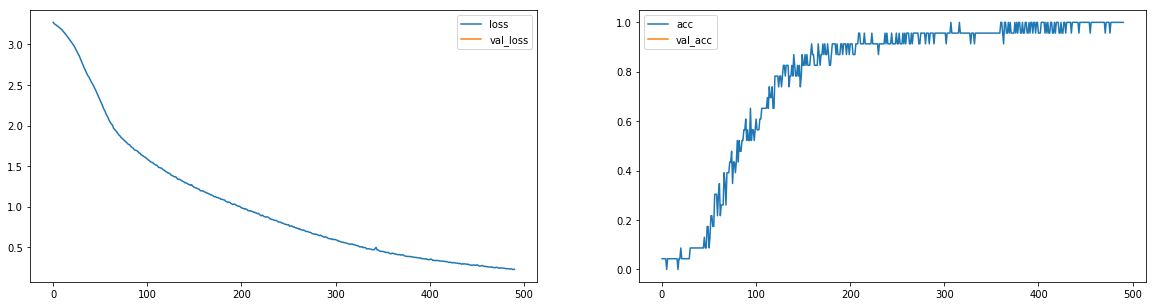

23/23 [==============================] - 0s - loss: 0.2293 - acc: 1.0000     
Epoch 492/500
23/23 [==============================] - 0s - loss: 0.2375 - acc: 1.0000     
Epoch 493/500
23/23 [==============================] - 0s - loss: 0.2275 - acc: 1.0000     
Epoch 494/500
23/23 [==============================] - 0s - loss: 0.2264 - acc: 1.0000     
Epoch 495/500
23/23 [==============================] - 0s - loss: 0.2224 - acc: 1.0000     
Epoch 496/500
23/23 [==============================] - 0s - loss: 0.2247 - acc: 1.0000     
Epoch 497/500
23/23 [==============================] - 0s - loss: 0.2270 - acc: 1.0000     
Epoch 498/500
23/23 [==============================] - 0s - loss: 0.2183 - acc: 1.0000     
Epoch 499/500
23/23 [==============================] - 0s - loss: 0.2178 - acc: 1.0000     
Epoch 500/500
23/23 [==============================] - 0s - loss: 0.2224 - acc: 1.0000     


In [93]:
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_naive_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_naive_3.fit(X, y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [94]:
get_score(X, y, model_naive_3)
get_some_model_predictions(model_naive_3, dataX)

Model Accuracy: 100.00%
['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> L
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> U
['S', 'T', 'U'] -> V
['T', 'U', 'V'] -> W
['U', 'V', 'W'] -> X
['V', 'W', 'X'] -> Y
['W', 'X', 'Y'] -> Z


Memorizó todas las secuencias de 3 letras. Cualquier secuencia que le ponga dara la respuesta correcta

In [95]:
get_some_model_predictions(model_naive_3, dataX[1:2])

['B', 'C', 'D'] -> E


Keras resetea el estado interno de la LSTM despues de cada batch

## Un solo batch

In [96]:
seq_length = 1
X, y, dataX, dataY, X_mlp, X_naive = prepare_dataset(phrase, seq_length = seq_length, verbose=True)

Primeros 3 pares:
A -> B
B -> C
C -> D

X e y ya formateados para RNN:
[[ 0.]] -> [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.03846154]] -> [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Dimensiones de X para RNN [samples, time steps, features]
(25, 1, 1)

Dimensiones de X_naive para RNN [samples, time steps, features]
(25, 1, 1)

Dimensiones de X_mpl para MLP [samples, features]
(25, 1)


In [104]:
input_shape=(X.shape[1], X.shape[2])
model_full_batch = get_naive_LSTM(input_shape)
model_full_batch.summary()

(1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_30 (Dense)             (None, 26)                858       
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
_________________________________________________________________


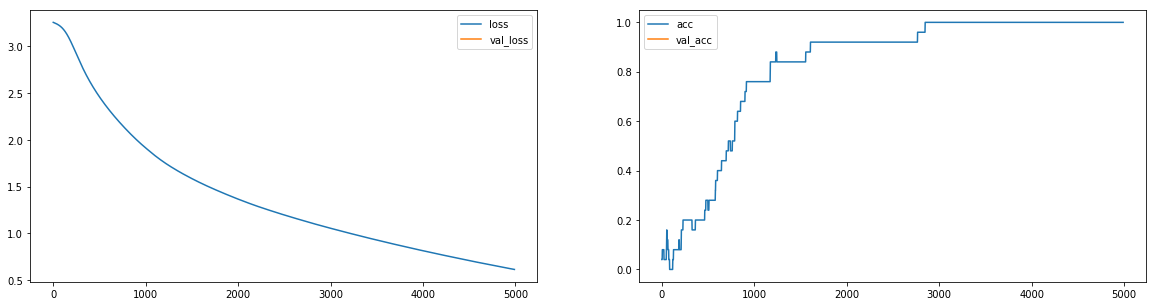

25/25 [==============================] - 0s - loss: 0.6139 - acc: 1.0000
Epoch 4992/5000
25/25 [==============================] - 0s - loss: 0.6137 - acc: 1.0000
Epoch 4993/5000
25/25 [==============================] - 0s - loss: 0.6135 - acc: 1.0000
Epoch 4994/5000
25/25 [==============================] - 0s - loss: 0.6133 - acc: 1.0000
Epoch 4995/5000
25/25 [==============================] - 0s - loss: 0.6131 - acc: 1.0000
Epoch 4996/5000
25/25 [==============================] - 0s - loss: 0.6129 - acc: 1.0000
Epoch 4997/5000
25/25 [==============================] - 0s - loss: 0.6128 - acc: 1.0000
Epoch 4998/5000
25/25 [==============================] - 0s - loss: 0.6126 - acc: 1.0000
Epoch 4999/5000
25/25 [==============================] - 0s - loss: 0.6124 - acc: 1.0000
Epoch 5000/5000
25/25 [==============================] - 0s - loss: 0.6122 - acc: 1.0000


In [105]:
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_full_batch.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_full_batch.fit(X, y, epochs=5000, batch_size=len(dataX), verbose=1, shuffle=False, callbacks=[plot_losses])

In [106]:
get_score(X, y, model_full_batch)
get_some_model_predictions(model_full_batch, dataX)

Model Accuracy: 100.00%
['A'] -> B
['B'] -> C
['C'] -> D
['D'] -> E
['E'] -> F
['F'] -> G
['G'] -> H
['H'] -> I
['I'] -> J
['J'] -> K
['K'] -> L
['L'] -> M
['M'] -> N
['N'] -> O
['O'] -> P
['P'] -> Q
['Q'] -> R
['R'] -> S
['S'] -> T
['T'] -> U
['U'] -> V
['V'] -> W
['W'] -> X
['X'] -> Y
['Y'] -> Z


In [108]:
i = 10
get_some_model_predictions(model_full_batch, dataX[i:i+1])

['K'] -> L
